### Import libraries and dataset connection

In [2]:
import os, sys
import re
from typing import List
from collections.abc import Callable

In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'
sns.set(rc = {'figure.figsize':(15, 8)})

top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

In [7]:
from ipywidgets import interact, interact_manual, FloatSlider

In [8]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, \
                      fetch_data, preprocess, create_dataset, Preprocessor, standardise_column_names, \
                          ASSETS_DIR

CONNECTION_DIR = '/Users/adhaene/Downloads/'
plt.style.use(os.path.join(ASSETS_DIR, 'graphmel.mplstyle'))


## Import data

In [9]:
files = os.listdir(os.path.join(ASSETS_DIR, 'results'))

files = sorted(list(zip(
    map(lambda fpath: os.path.getmtime(os.path.join(ASSETS_DIR, 'results', fpath)), files),
    files)), key=lambda t: t[0], reverse=True)

files[:6]

[(1639417603.1498682, 'TRAIN_METRICS_2021-12-13 18:42:30.087070.csv'),
 (1639417229.7001288, 'hpopt-reduced-feats.json'),
 (1639403800.5351427, 'TRAIN_METRICS_2021-12-13 14:54:19.625171.csv'),
 (1639391413.0403504, 'TRAIN_METRICS_2021-12-13 11:28:24.549444.csv'),
 (1639310767.0595803, 'TRAIN_METRICS_2021-12-12 12:59:22.269245.csv'),
 (1639310354.2191226, 'TRAIN_METRICS_2021-12-12 12:52:31.374146.csv')]

In [10]:
results_files = [
    # (0.5, 'TRAIN_METRICS_2021-12-12 12:59:22.269245.csv'),
    # (1.0, 'TRAIN_METRICS_2021-12-12 12:52:31.374146.csv'),
    # (0.75, 'TRAIN_METRICS_2021-12-12 12:00:28.802609.csv'),
    # (0.0, 'TRAIN_METRICS_2021-12-12 11:53:07.344919.csv'),
    (0.25, 'TRAIN_METRICS_2021-12-12 11:38:23.871063.csv'),    
]

df = pd.DataFrame()

for name, filename in results_files:
    
    tdf = pd.read_csv(os.path.join(ASSETS_DIR, 'results', filename), index_col=0)
    tdf['run'] = name
    
    tdf.reset_index(inplace=True)
    
    df = pd.concat([df, tdf])
    
df.reset_index(inplace=True)

<AxesSubplot:>

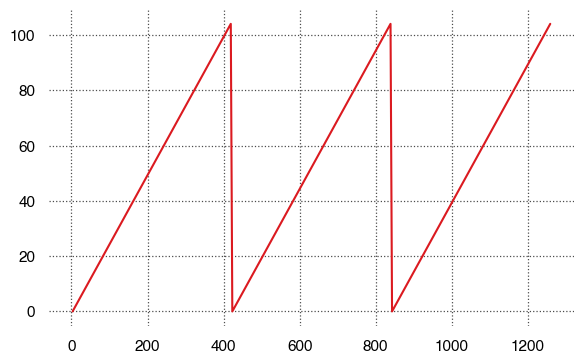

In [23]:
df[df.metric == 'Accuracy - validation'].step.plot()

In [30]:
df['ensemble'] = 0
df['ensemble'].loc[0:419] = 1
df['ensemble'].loc[420:839] = 2
df['ensemble'].loc[840:] = 3

In [31]:
df

,level_0,index,metric,value,step,run,ensemble
0,0,0,Loss - training,0.418400,0,0.25,1
1,1,1,Accuracy - training,0.648649,0,0.25,1
2,2,2,Loss - validation,0.244544,0,0.25,1
3,3,3,Accuracy - validation,0.550000,0,0.25,1
4,4,4,Loss - training,0.416304,1,0.25,1
...,...,...,...,...,...,...,...
1255,1255,1255,Accuracy - validation,0.500000,103,0.25,3
1256,1256,1256,Loss - training,0.074799,104,0.25,3
1257,1257,1257,Accuracy - training,0.891892,104,0.25,3
1258,1258,1258,Loss - validation,1.573618,104,0.25,3


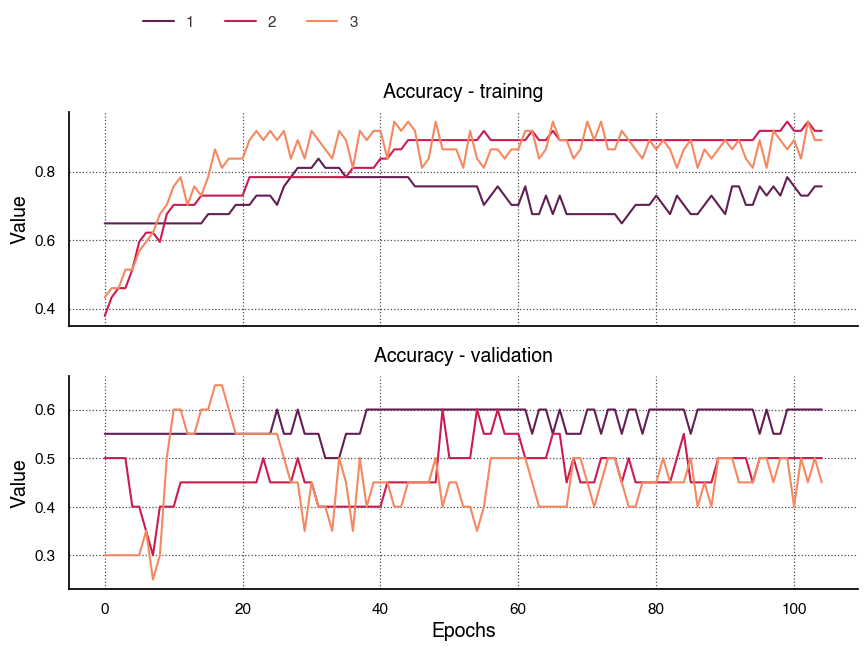

In [34]:
g = sns.FacetGrid(data=df[df.metric.isin(['Accuracy - training', 'Accuracy - validation'])], row='metric', sharey=False, height=3, aspect=3)

g.map_dataframe(sns.lineplot, x='step', y='value', hue='ensemble', palette=sns.color_palette("rocket", n_colors=3))
g.add_legend(loc="upper center", bbox_to_anchor=(0.25, 1.10), ncol=5)

g.set_axis_labels("Epochs", "Value")
g.set_titles(row_template="{row_name}")

In [71]:
tf1 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:15:18.817083.csv'),
    index_col=0)
tf1['suspicious'] = 0.75

tf2 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:02:12.968217.csv'),
    index_col=0)
tf2['suspicious'] = 0.0

tf3 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 20:55:59.367823.csv'),
    index_col=0)
tf3['suspicious'] = 0.5

tf = pd.concat([tf1, tf2, tf3]).reset_index(drop=True)

tf

,metric,value,suspicious
0,Accuracy - testing,0.411765,0.75
1,ROC AUC - testing,0.392857,0.75
2,Precision - testing,0.500000,0.75
3,Recall - testing,0.500000,0.75
4,Fscore - testing,0.500000,0.75
5,Accuracy - testing,0.458333,0.00
6,ROC AUC - testing,0.433333,0.00
7,Precision - testing,0.571429,0.00
8,Recall - testing,0.533333,0.00
9,Fscore - testing,0.551724,0.00


In [72]:
tf.pivot(index='suspicious', columns='metric')

value                                       \
metric     Accuracy - testing Fscore - testing Precision - testing   
suspicious                                                           
0.00                 0.458333         0.551724            0.571429   
0.50                 0.666667         0.750000            0.818182   
0.75                 0.411765         0.500000            0.500000   

                                               
metric     ROC AUC - testing Recall - testing  
suspicious                                     
0.00                0.433333         0.533333  
0.50                0.646154         0.692308  
0.75                0.392857         0.500000